In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [2]:
# --- Metrics ---
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Read data

In [3]:
df = pd.read_csv("df_final_bh_amazonas.csv")

In [4]:
df.head()

,Date,DayOfWeek,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,IsDayAfterHoliday,temp_max,temp_min,temp_mean,humidity_max,humidity_min,NUMBER_INT,CO,MP10,O3,MP2.5,SO2
0,2015-01-01,Thu,3,1,1,0,1,0,33.9,20.6,25.912500,89.0,32.0,30,0.0,NaN,68.0,NaN,82.0
1,2015-01-02,Fri,4,1,1,0,0,1,32.9,21.0,26.050000,87.0,38.0,43,0.0,NaN,79.0,NaN,83.0
2,2015-01-03,Sat,5,1,1,1,0,0,33.5,20.2,26.683333,83.0,38.0,23,0.0,NaN,44.0,NaN,83.0
3,2015-01-04,Sun,6,1,1,1,0,0,30.6,22.2,25.641667,81.0,43.0,20,0.0,NaN,49.0,NaN,82.0
4,2015-01-05,Mon,0,2,1,0,0,0,30.8,20.8,25.520833,79.0,36.0,51,0.0,NaN,59.0,NaN,82.0


In [5]:
df.count()

Date                 1826
DayOfWeek            1826
DayOfWeekNum         1826
WeekOfYear           1826
Month                1826
IsWeekend            1826
IsHoliday            1826
IsDayAfterHoliday    1826
temp_max             1826
temp_min             1826
temp_mean            1826
humidity_max         1826
humidity_min         1826
NUMBER_INT           1826
CO                   1581
MP10                 1457
O3                   1265
MP2.5                1195
SO2                  1091
dtype: int64

### Set features

In [6]:
selected_cols_final = [
    'Date',
    'DayOfWeekNum',
    'WeekOfYear',
    'Month',
    'IsWeekend',
    'IsHoliday',
    'NUMBER_INT',
    'CO',
    'temp_max',
    'temp_min',
    'humidity_max',
]

df_final = df[selected_cols_final].copy()

In [7]:
# add lag

df_final['CO_lag1'] = df_final['CO'].shift(1)
df_final['CO_lag2'] = df_final['CO'].shift(2)
df_final['CO_lag3'] = df_final['CO'].shift(3)

df_final['temp_min_lag1'] = df_final['temp_min'].shift(1)
df_final['temp_min_lag2'] = df_final['temp_min'].shift(2)
df_final['temp_min_lag3'] = df_final['temp_min'].shift(3)

# df_final['humidity_max_lag1'] = df_final['humidity_max'].shift(1)
# df_final['humidity_max_lag2'] = df_final['humidity_max'].shift(2)
# df_final['humidity_max_lag3'] = df_final['humidity_max'].shift(3)

In [8]:
df_final = df_final.dropna()

In [9]:
# Check non-null counts and data types
df_final.info()

# Check descriptive statistics
df_final.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
Index: 1417 entries, 3 to 1752
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1417 non-null   object 
 1   DayOfWeekNum   1417 non-null   int64  
 2   WeekOfYear     1417 non-null   int64  
 3   Month          1417 non-null   int64  
 4   IsWeekend      1417 non-null   int64  
 5   IsHoliday      1417 non-null   int64  
 6   NUMBER_INT     1417 non-null   int64  
 7   CO             1417 non-null   float64
 8   temp_max       1417 non-null   float64
 9   temp_min       1417 non-null   float64
 10  humidity_max   1417 non-null   float64
 11  CO_lag1        1417 non-null   float64
 12  CO_lag2        1417 non-null   float64
 13  CO_lag3        1417 non-null   float64
 14  temp_min_lag1  1417 non-null   float64
 15  temp_min_lag2  1417 non-null   float64
 16  temp_min_lag3  1417 non-null   float64
dtypes: float64(10), int64(6), object(1)
memory usage: 199.3+ 

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,1417,1417,2019-10-19,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfWeekNum,1417.0,NaN,NaN,NaN,2.988709,2.008777,0.0,1.0,3.0,5.0,6.0
WeekOfYear,1417.0,NaN,NaN,NaN,26.155963,14.377,1.0,14.0,26.0,38.0,53.0
Month,1417.0,NaN,NaN,NaN,6.416373,3.292083,1.0,4.0,7.0,9.0,12.0
IsWeekend,1417.0,NaN,NaN,NaN,0.286521,0.452295,0.0,0.0,0.0,1.0,1.0
IsHoliday,1417.0,NaN,NaN,NaN,0.023289,0.150872,0.0,0.0,0.0,0.0,1.0
NUMBER_INT,1417.0,NaN,NaN,NaN,47.647142,15.924424,11.0,36.0,46.0,59.0,94.0
CO,1417.0,NaN,NaN,NaN,0.38391,0.489403,0.0,0.0,0.0,1.0,2.0
temp_max,1417.0,NaN,NaN,NaN,28.321948,2.972889,17.8,26.4,28.5,30.4,37.7
temp_min,1417.0,NaN,NaN,NaN,17.719831,2.673525,7.3,16.0,18.3,19.6,24.1


In [10]:
df_final.dtypes

Date              object
DayOfWeekNum       int64
WeekOfYear         int64
Month              int64
IsWeekend          int64
IsHoliday          int64
NUMBER_INT         int64
CO               float64
temp_max         float64
temp_min         float64
humidity_max     float64
CO_lag1          float64
CO_lag2          float64
CO_lag3          float64
temp_min_lag1    float64
temp_min_lag2    float64
temp_min_lag3    float64
dtype: object

## Train

In [11]:
df_final['Date'] = pd.to_datetime(df_final['Date'])
# df_final = df_final.sort_values(by='Date')

# remove the last 5 days (account for lag ...)
# df_final = df_final[:-5]

# Range for training and testing (4 years for training, 1 year for validation)
min_year = df_final['Date'].dt.year.min()
train_mask = df_final['Date'].dt.year < (min_year + 4)
val_mask = df_final['Date'].dt.year == (min_year + 4)



df_train = df_final[train_mask]
df_val = df_final[val_mask]

df_train = df_train.drop(columns=['Date'])
df_val = df_val.drop(columns=['Date'])

X = df_final.drop(columns=['Date', 'NUMBER_INT'])
y = df_final['NUMBER_INT']


X_train = df_train.drop(columns=['NUMBER_INT'])
y_train = df_train['NUMBER_INT']

X_val = df_val.drop(columns=['NUMBER_INT'])
y_val = df_val['NUMBER_INT']

In [12]:
df_train.head()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,CO,temp_max,temp_min,humidity_max,CO_lag1,CO_lag2,CO_lag3,temp_min_lag1,temp_min_lag2,temp_min_lag3
3,6,1,1,1,0,20,0.0,30.6,22.2,81.0,0.0,0.0,0.0,20.2,21.0,20.6
4,0,2,1,0,0,51,0.0,30.8,20.8,79.0,0.0,0.0,0.0,22.2,20.2,21.0
5,1,2,1,0,0,23,0.0,29.5,20.5,79.0,0.0,0.0,0.0,20.8,22.2,20.2
6,2,2,1,0,0,43,0.0,28.0,19.9,78.0,0.0,0.0,0.0,20.5,20.8,22.2
18,0,4,1,0,0,37,0.0,32.6,21.2,61.0,0.0,0.0,0.0,18.5,20.4,20.9


In [13]:
df_train.tail()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,CO,temp_max,temp_min,humidity_max,CO_lag1,CO_lag2,CO_lag3,temp_min_lag1,temp_min_lag2,temp_min_lag3
1456,3,52,12,0,0,60,1.0,24.8,18.8,92.0,1.0,1.0,1.0,18.6,18.5,18.5
1457,4,52,12,0,0,61,1.0,25.4,18.5,92.0,1.0,1.0,1.0,18.8,18.6,18.5
1458,5,52,12,1,0,30,1.0,27.5,17.7,92.0,1.0,1.0,1.0,18.5,18.8,18.6
1459,6,52,12,1,0,26,1.0,27.3,18.5,93.0,1.0,1.0,1.0,17.7,18.5,18.8
1460,0,1,12,0,0,61,1.0,25.9,19.2,92.0,1.0,1.0,1.0,18.5,17.7,18.5


In [14]:
df_val.head()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,CO,temp_max,temp_min,humidity_max,CO_lag1,CO_lag2,CO_lag3,temp_min_lag1,temp_min_lag2,temp_min_lag3
1461,1,1,1,0,1,44,1.0,27.9,19.2,92.0,1.0,1.0,1.0,19.2,18.5,17.7
1462,2,1,1,0,0,45,1.0,31.1,18.9,90.0,1.0,1.0,1.0,19.2,19.2,18.5
1463,3,1,1,0,0,28,1.0,30.7,20.4,88.0,1.0,1.0,1.0,18.9,19.2,19.2
1464,4,1,1,0,0,37,1.0,25.4,19.0,91.0,1.0,1.0,1.0,20.4,18.9,19.2
1465,5,1,1,1,0,36,1.0,30.1,18.6,91.0,1.0,1.0,1.0,19.0,20.4,18.9


In [15]:
df_val.tail()

,DayOfWeekNum,WeekOfYear,Month,IsWeekend,IsHoliday,NUMBER_INT,CO,temp_max,temp_min,humidity_max,CO_lag1,CO_lag2,CO_lag3,temp_min_lag1,temp_min_lag2,temp_min_lag3
1722,3,38,9,0,0,51,1.0,35.0,22.0,46.0,1.0,0.0,0.0,18.6,18.7,19.0
1731,5,39,9,1,0,29,0.0,27.7,17.3,82.0,1.0,1.0,0.0,14.7,15.9,16.0
1732,6,39,9,1,0,25,0.0,29.8,18.6,81.0,0.0,1.0,1.0,17.3,14.7,15.9
1733,0,40,9,0,0,69,0.0,31.0,18.1,82.0,0.0,0.0,1.0,18.6,17.3,14.7
1752,5,42,10,1,0,35,0.0,36.0,20.8,61.0,0.0,0.0,0.0,20.2,19.7,19.9


## Test (10x with cv)

In [16]:
results = []
results30 = []

param_grid = {
    'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160],
    'max_depth': [2, 4, 6, 10, 12, 14, 16, 18, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [17]:
for i in range(10):
    grid_search = GridSearchCV(
        estimator=XGBRegressor(random_state=i),
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print(f"\nRun {i+1} Best Hyperparameters:")
    print("Best Hyperparameters:", grid_search.best_params_)
    print(f"Best R-squared: {grid_search.best_score_:.4f}")

    best_xgb_model = grid_search.best_estimator_
    y_pred = best_xgb_model.predict(X_val)

    # Metrics 1y
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    mape_val = mape(y_val, y_pred)
    smape_val = smape(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    corr = np.corrcoef(y_val, y_pred)[0, 1]

    # Metrics 30d
    y_pred_30d = best_xgb_model.predict(X_val[:30])
    y_val_30 = y_val[:30]
    mse_30d = mean_squared_error(y_val_30, y_pred_30d)
    rmse_30d = np.sqrt(mse_30d)
    mae_30d = mean_absolute_error(y_val_30, y_pred_30d)
    mape_val_30d = mape(y_val_30, y_pred_30d)
    smape_val_30d = smape(y_val_30, y_pred_30d)
    r2_30d = r2_score(y_val_30, y_pred_30d)
    corr_30d = np.corrcoef(y_val_30, y_pred_30d)[0, 1]

    results.append({
        'run': i+1,
        'random_state': i,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape_val,
        'sMAPE': smape_val,
        'R2': r2,
        'Correlation': corr,
        'Best Params': grid_search.best_params_,
        'Best Cross-validated R-squared': grid_search.best_score_
    })

    results30.append({
        'run': i+1,
        'random_state': i,
        'MSE_30d': mse_30d,
        'RMSE_30d': rmse_30d,
        'MAE_30d': mae_30d,
        'MAPE_30d': mape_val_30d,
        'sMAPE_30d': smape_val_30d,
        'R2_30d': r2_30d,
        'Correlation_30d': corr_30d
    })




Run 1 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 0.9}
Best R-squared: 0.5859

Run 2 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.9}
Best R-squared: 0.5873

Run 3 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 0.8}
Best R-squared: 0.5885

Run 4 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.9}
Best R-squared: 0.5868

Run 5 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 60, 'subsample': 0.8}
Best R-squared: 0.5861

Run 6 Best Hyperparameters:
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_

### Results 1y

In [18]:
results_df = pd.DataFrame(results)
results_df

,run,random_state,MSE,RMSE,MAE,MAPE,sMAPE,R2,Correlation,Best Params,Best Cross-validated R-squared
0,1,0,133.957474,11.574000,8.785892,16.130878,17.442880,0.485433,0.796650,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.585850
1,2,1,134.448868,11.595209,8.799062,16.299601,17.649976,0.483546,0.796185,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.587347
2,3,2,131.434647,11.464495,8.710226,16.015862,17.254131,0.495124,0.802975,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.588474
3,4,3,130.958237,11.443699,8.581518,15.947897,17.149053,0.496954,0.791151,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.586817
4,5,4,133.776306,11.566171,8.792451,16.169101,17.533132,0.486129,0.801492,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.586124
5,6,5,129.656723,11.386691,8.617188,15.886334,17.117623,0.501954,0.798074,"{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.587878
6,7,6,133.601303,11.558603,8.811749,16.166680,17.458760,0.486802,0.799685,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.587341
7,8,7,133.269913,11.544259,8.796316,16.279336,17.614769,0.488074,0.797232,"{'colsample_bytree': 1.0, 'learning_rate': 0.1...",0.587427
8,9,8,130.922760,11.442148,8.638281,15.982414,17.244825,0.497090,0.796639,"{'colsample_bytree': 1.0, 'learning_rate': 0.2...",0.587403
9,10,9,133.264084,11.544006,8.798377,16.418039,17.787867,0.488097,0.794420,"{'colsample_bytree': 0.8, 'learning_rate': 0.2...",0.586932


In [19]:
results_df.describe()

,run,random_state,MSE,RMSE,MAE,MAPE,sMAPE,R2,Correlation,Best Cross-validated R-squared
count,10.00000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,4.50000,132.529031,11.511928,8.733106,16.129614,17.425302,0.490920,0.797450,0.587159
std,3.02765,3.02765,1.633545,0.071057,0.088838,0.171351,0.226994,0.006275,0.003400,0.000775
min,1.00000,0.00000,129.656723,11.386691,8.581518,15.886334,17.117623,0.483546,0.791151,0.585850
25%,3.25000,2.25000,131.077339,11.448898,8.656267,15.990776,17.247152,0.486297,0.796298,0.586846
50%,5.50000,4.50000,133.266998,11.544133,8.789172,16.148779,17.450820,0.488086,0.796941,0.587344
75%,7.75000,6.75000,133.732555,11.564279,8.797862,16.251777,17.594360,0.496497,0.799282,0.587421
max,10.00000,9.00000,134.448868,11.595209,8.811749,16.418039,17.787867,0.501954,0.802975,0.588474


### results 30d

In [20]:
results_df_30 = pd.DataFrame(results30)
results_df_30

,run,random_state,MSE_30d,RMSE_30d,MAE_30d,MAPE_30d,sMAPE_30d,R2_30d,Correlation_30d
0,1,0,52.377087,7.237202,6.030457,15.346600,16.297705,0.217747,0.690179
1,2,1,53.949341,7.345021,6.190073,15.875651,16.914865,0.194265,0.694321
2,3,2,49.230671,7.016457,5.972756,15.345355,16.023925,0.264738,0.679849
3,4,3,52.818787,7.267653,5.962374,15.470092,16.260368,0.211150,0.671753
4,5,4,56.572643,7.521479,6.347423,16.131647,17.282567,0.155086,0.681477
5,6,5,49.221249,7.015786,5.896341,15.213622,16.031872,0.264879,0.695411
6,7,6,49.618652,7.044051,5.933110,15.184212,15.957575,0.258944,0.681368
7,8,7,57.069996,7.554469,6.421196,16.601109,17.693823,0.147658,0.669054
8,9,8,53.354454,7.304413,6.188093,15.824236,16.908666,0.203150,0.696031
9,10,9,58.639851,7.657666,6.495984,17.052982,18.470763,0.124212,0.702386


In [21]:
results_df_30.describe()

,run,random_state,MSE_30d,RMSE_30d,MAE_30d,MAPE_30d,sMAPE_30d,R2_30d,Correlation_30d
count,10.00000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,4.50000,53.285273,7.296420,6.143781,15.804550,16.784213,0.204183,0.686183
std,3.02765,3.02765,3.361395,0.229813,0.217867,0.629989,0.836079,0.050203,0.011125
min,1.00000,0.00000,49.221249,7.015786,5.896341,15.184212,15.957575,0.124212,0.669054
25%,3.25000,2.25000,50.308261,7.092339,5.964969,15.345666,16.088996,0.164881,0.680229
50%,5.50000,4.50000,53.086620,7.286033,6.109275,15.647164,16.603186,0.207150,0.685828
75%,7.75000,6.75000,55.916818,7.477364,6.308085,16.067648,17.190642,0.248645,0.695138
max,10.00000,9.00000,58.639851,7.657666,6.495984,17.052982,18.470763,0.264879,0.702386


## Plots    

In [22]:
best_idx = results_df['RMSE'].idxmin()
print(f"Best run based on RMSE: Run {results_df.loc[best_idx, 'run']} with RMSE = {results_df.loc[best_idx, 'RMSE']:.2f}")

best_params = results_df.loc[best_idx, 'Best Params']
print(f"Best parameters: {best_params}")

best_random_state = results_df.loc[best_idx, 'run'] - 1 

# Rebuild the best model
best_model = XGBRegressor(random_state=best_random_state, **best_params)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_val)


Best run based on RMSE: Run 6 with RMSE = 11.39
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 80, 'subsample': 0.9}


### 1y

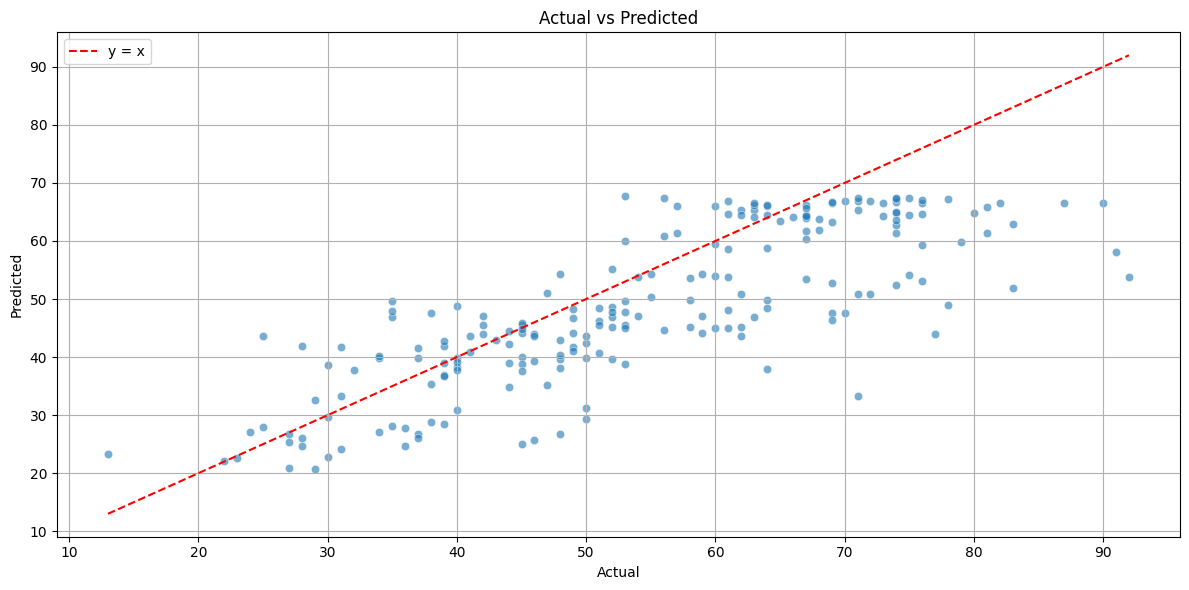

In [23]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val[:], y=y_pred_best, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

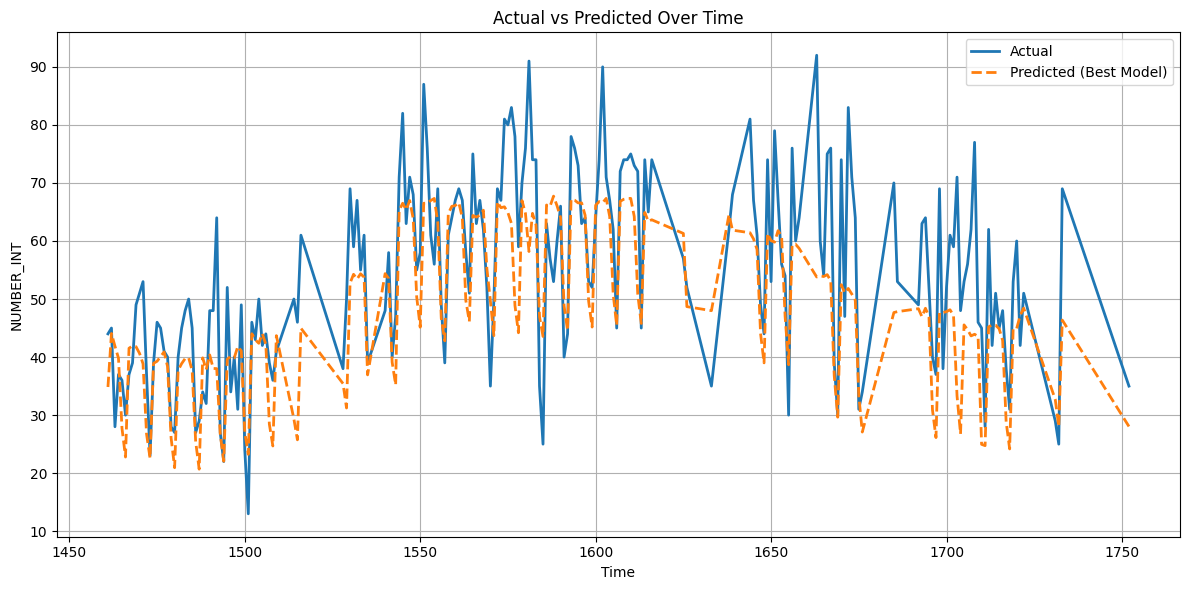

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val.values, label='Actual', linewidth=2)
plt.plot(y_val.index, y_pred_best, label='Predicted (Best Model)', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('NUMBER_INT')
plt.title(f'Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 30d

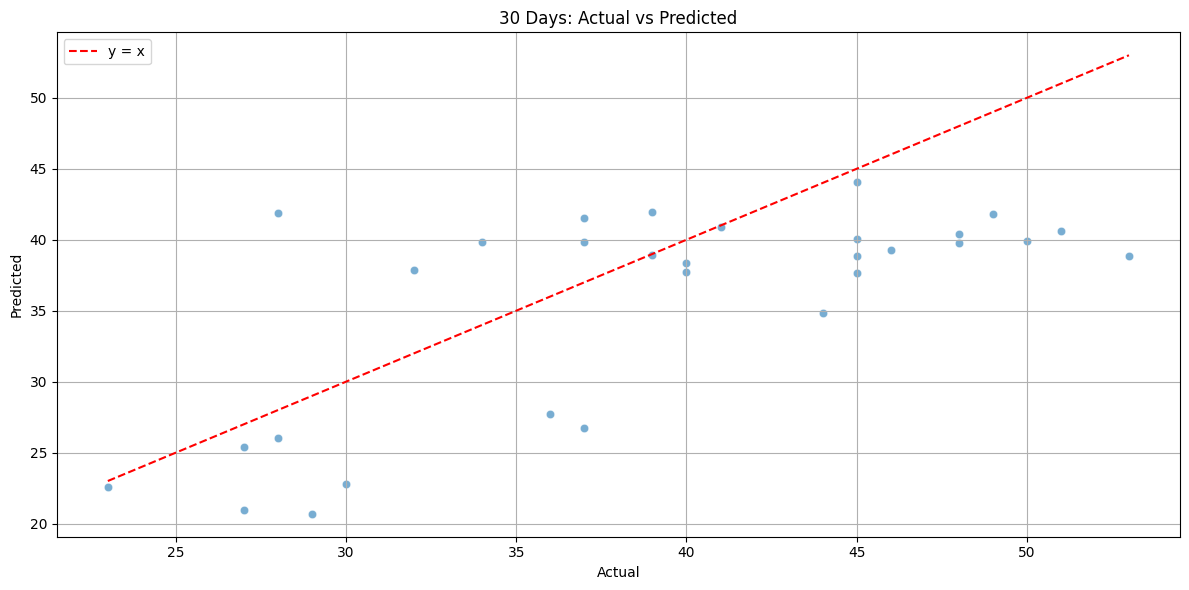

In [25]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val[:30], y=y_pred_best[:30], alpha=0.6)
plt.plot([y_val[:30].min(), y_val[:30].max()], [y_val[:30].min(), y_val[:30].max()], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('30 Days: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


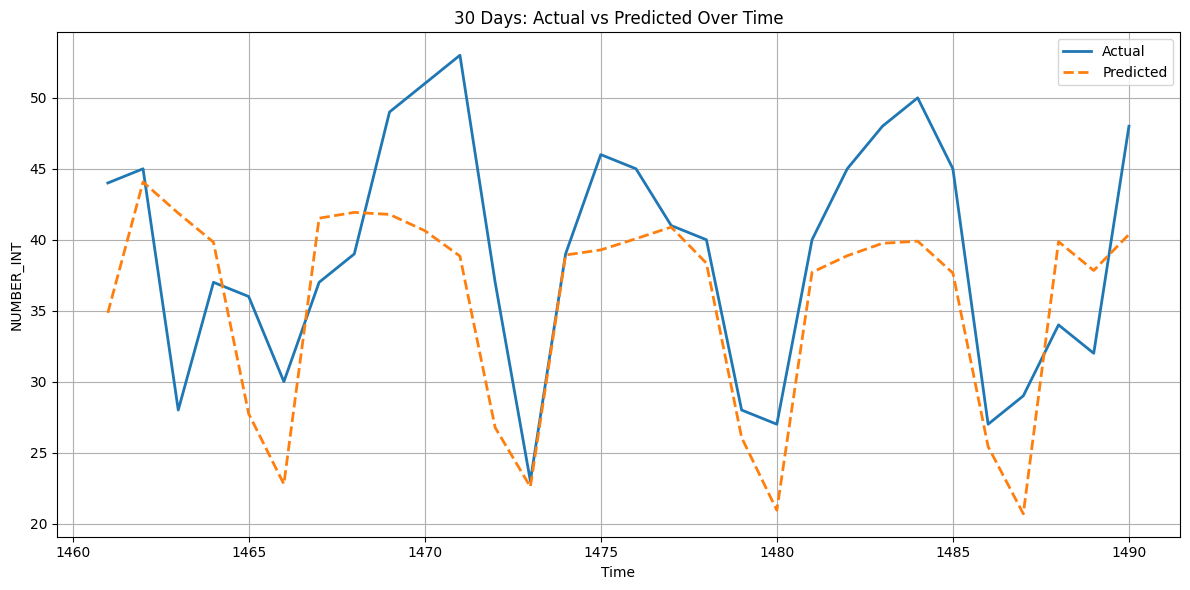

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(y_val.index[:30], y_val[:30].values, label='Actual', linewidth=2)
plt.plot(y_val.index[:30], y_pred_best[:30], label='Predicted', linewidth=2, linestyle='--')
plt.xlabel('Time')
plt.ylabel('NUMBER_INT')
plt.title('30 Days: Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

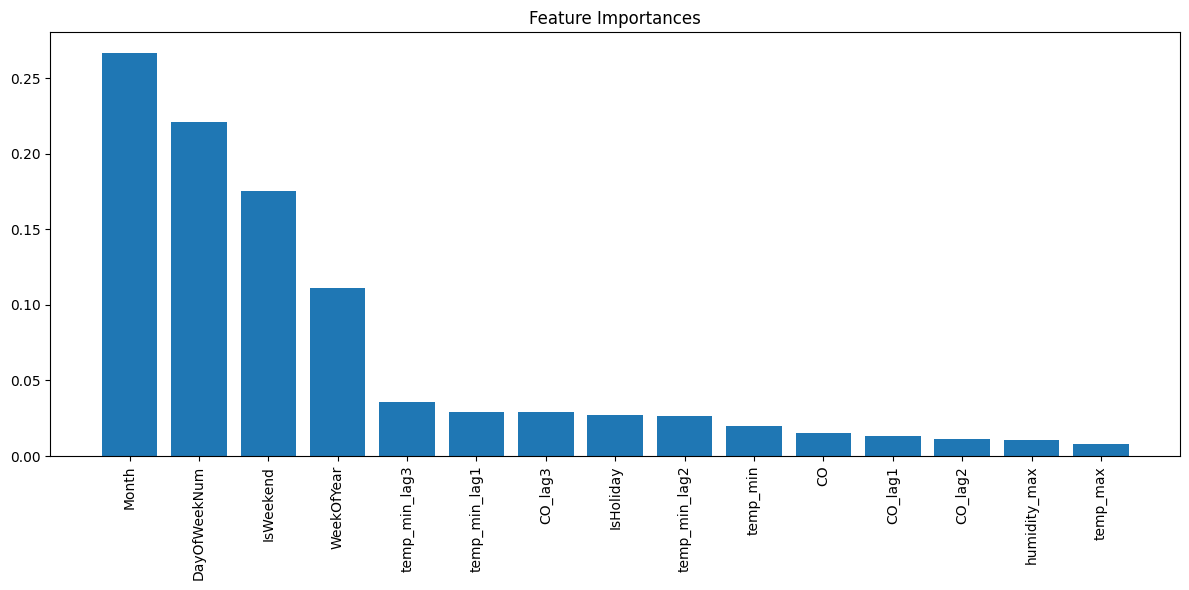

In [27]:
importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()